# Telcom Customer Churn Prediction
Churn prediction is identifying customers that are most likely to leave a service.

## Table of Contents
* [EDA & Data Cleaning](#section-one)

    - [What This Step Does](#subsection-one)
    - [Summarize Numerical and Categorical Data](#subsection-two)
    - [Churn Rate Analysis](#subsection-three)
    - [Distribution of Numerical Features](#subsection-four)
    - [Categorical Insights on Churn](#subsection-five)
      
* [Correlation Analysis](#section-two)

    - [Correlation Insights](#subsection-one)
    - [Churn Rate Across Tenure Segments](#subsection-two)
    - [Survival Analysis for Churn Prediction](#subsection-three)
    - [Impact of Monthly & Total Charges on Churn](#subsection-four)
    - [Clustering to Find Customer Segments](#subsection-five)
    - [Feature Importance with Decision Trees](#subsection-six)
      
* [Machine Learning Pipeline](#section-three)

    - [Data Preprocessing](#subsection-one)
    - [Train-Test Split & Feature Scaling](#subsection-two)
    - [Model Training: Logistic Regression, Random Forest, XGBoost](#subsection-three)
    - [Model Comparison & Evaluation](#subsection-four)
    - [Hyperparameter Tuning](#subsection-five)
    - [Feature Importance Analysis](#subsection-six)
      
* [Explainability & Interpretability](#section-four)

    - [SHAP Analysis](#subsection-one)
    - [Individual Prediction Explanation](#subsection-two)
      
* [Final Summary & Recommendations](#section-five)

### Import Required Libraries

In [3]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,roc_curve, auc
from lifelines import KaplanMeierFitter
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

* Loads the dataset 
* Prints dataset structure (column types, non-null counts) 
* Provides summary stats for numerical columns 
* Checks for missing values

In [5]:
# Load the dataset
file_path = "Telcom_Customer_Churn.csv"
df = pd.read_csv(file_path)

# Get basic info about the dataset
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(None,
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovie

### EDA & Data Cleaning
we’ll check for missing values, handle outliers, and visualize key distributions.

In [7]:
# Convert 'TotalCharges' to numeric, forcing errors to NaN (likely empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values after conversion
missing_values = df.isnull().sum()

# Display the number of missing values per column
missing_values


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# Check if missing TotalCharges corresponds to tenure = 0
df[df['TotalCharges'].isna()][['tenure', 'TotalCharges']]


,tenure,TotalCharges
488,0,NaN
753,0,NaN
936,0,NaN
1082,0,NaN
1340,0,NaN
3331,0,NaN
3826,0,NaN
4380,0,NaN
5218,0,NaN
6670,0,NaN


In [9]:
# Replace NaNs in 'TotalCharges' with 0
df['TotalCharges'].fillna(0, inplace=True)

# Convert 'SeniorCitizen' to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')

# Verify the changes
df.info(), df.isnull().sum().sum()  # Second check ensures no missing values remain


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   object  
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   object  
 4   Dependents        7043 non-null   object  
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   object  
 7   MultipleLines     7043 non-null   object  
 8   InternetService   7043 non-null   object  
 9   OnlineSecurity    7043 non-null   object  
 10  OnlineBackup      7043 non-null   object  
 11  DeviceProtection  7043 non-null   object  
 12  TechSupport       7043 non-null   object  
 13  StreamingTV       7043 non-null   object  
 14  StreamingMovies   7043 non-null   object  
 15  Contract          7043 non-null   object  
 16  PaperlessBilling  7043 n

(None, 0)

### What This Step Does:
* Handles missing values (fills numerical with median, categorical with mode)
* Detects outliers using boxplots 
* Checks for class imbalance (important for model performance!)

### Summarize numerical and categorical data

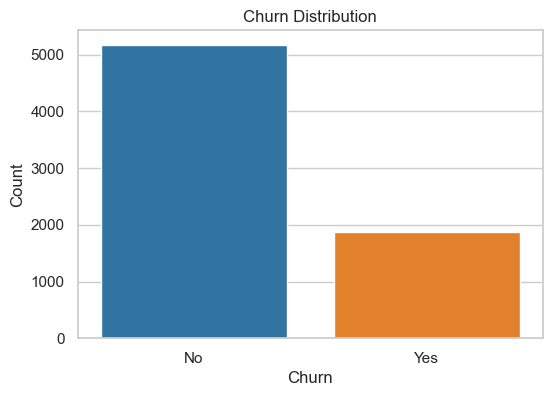

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


In [12]:
# Set style
sns.set_theme(style="whitegrid")

# Summary statistics for numerical columns
numerical_summary = df.describe()

# Count plots for categorical variables (churn distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=df, hue="Churn", palette=["#1f77b4", "#ff7f0e"], legend=False)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Display summary statistics
print(numerical_summary)

#### Churn Rate: 
* Visually, there are fewer churned customers than non-churned ones—suggesting an imbalanced dataset. (We'll quantify it soon.)

#### Numerical Summary:

* tenure: Ranges from 0 to 72 months, with a median of 29 months—suggests many customers churn within the first few years.
* MonthlyCharges: Varies from ($18.25  to  $118.75) — we'll check if higher charges correlate with churn.
* TotalCharges: Wide spread (0 to $8,684.80)—since some values are 0, we should examine how tenure influences it.

### Distribution of the numerical features of the customers on the platform

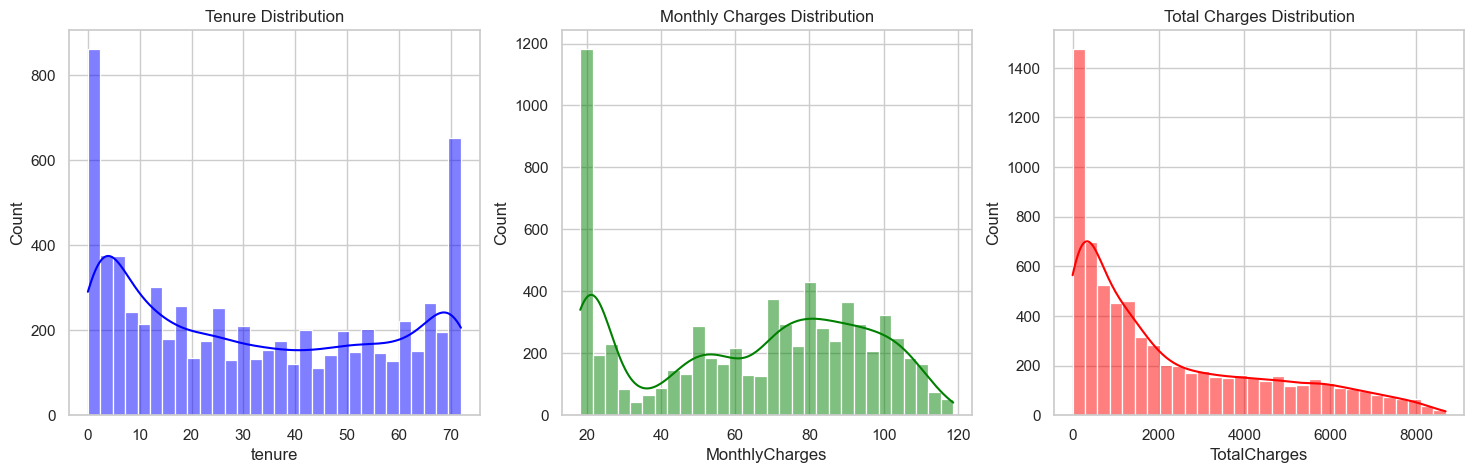

In [15]:
# Histograms for numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Tenure Distribution")

sns.histplot(df['MonthlyCharges'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title("Monthly Charges Distribution")

sns.histplot(df['TotalCharges'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title("Total Charges Distribution")

plt.show()

##### Histograms:

* Tenure: Peaks at 0 and gradually declines—suggests many customers leave early.
* MonthlyCharges: Right-skewed, meaning more customers have lower charges.
* TotalCharges: Follows a similar pattern but is more spread out (as expected).

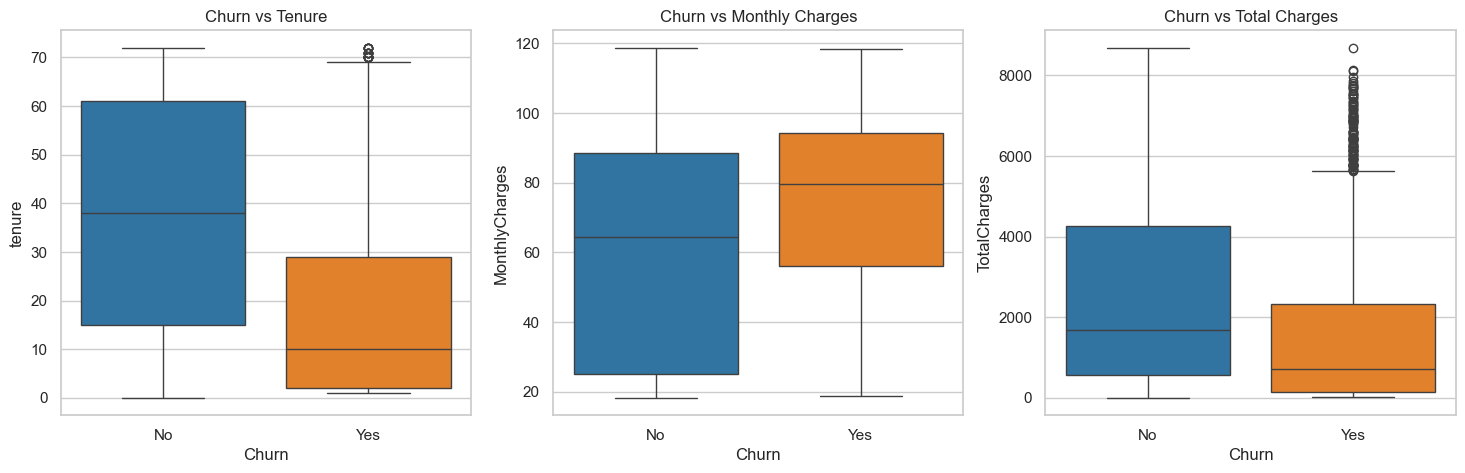

In [17]:
# Box plots for Churn vs Numerical Variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x="Churn", y="tenure", hue="Churn", data=df, ax=axes[0], palette=["#1f77b4", "#ff7f0e"])
axes[0].set_title("Churn vs Tenure")

sns.boxplot(x="Churn", y="MonthlyCharges", hue="Churn", data=df, ax=axes[1], palette=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Churn vs Monthly Charges")

sns.boxplot(x="Churn", y="TotalCharges", hue="Churn", data=df, ax=axes[2], palette=["#1f77b4", "#ff7f0e"])
axes[2].set_title("Churn vs Total Charges")

plt.show()

#### Churn vs. Numerical Features (Box Plots):

* Churners have significantly lower tenure—confirming early exits are a big factor.
* Churners tend to have higher MonthlyCharges—possible pain point?
* TotalCharges is lower for churners—makes sense, since they leave early.

### Categorical variable impact on churn (e.g., contract type, internet service)

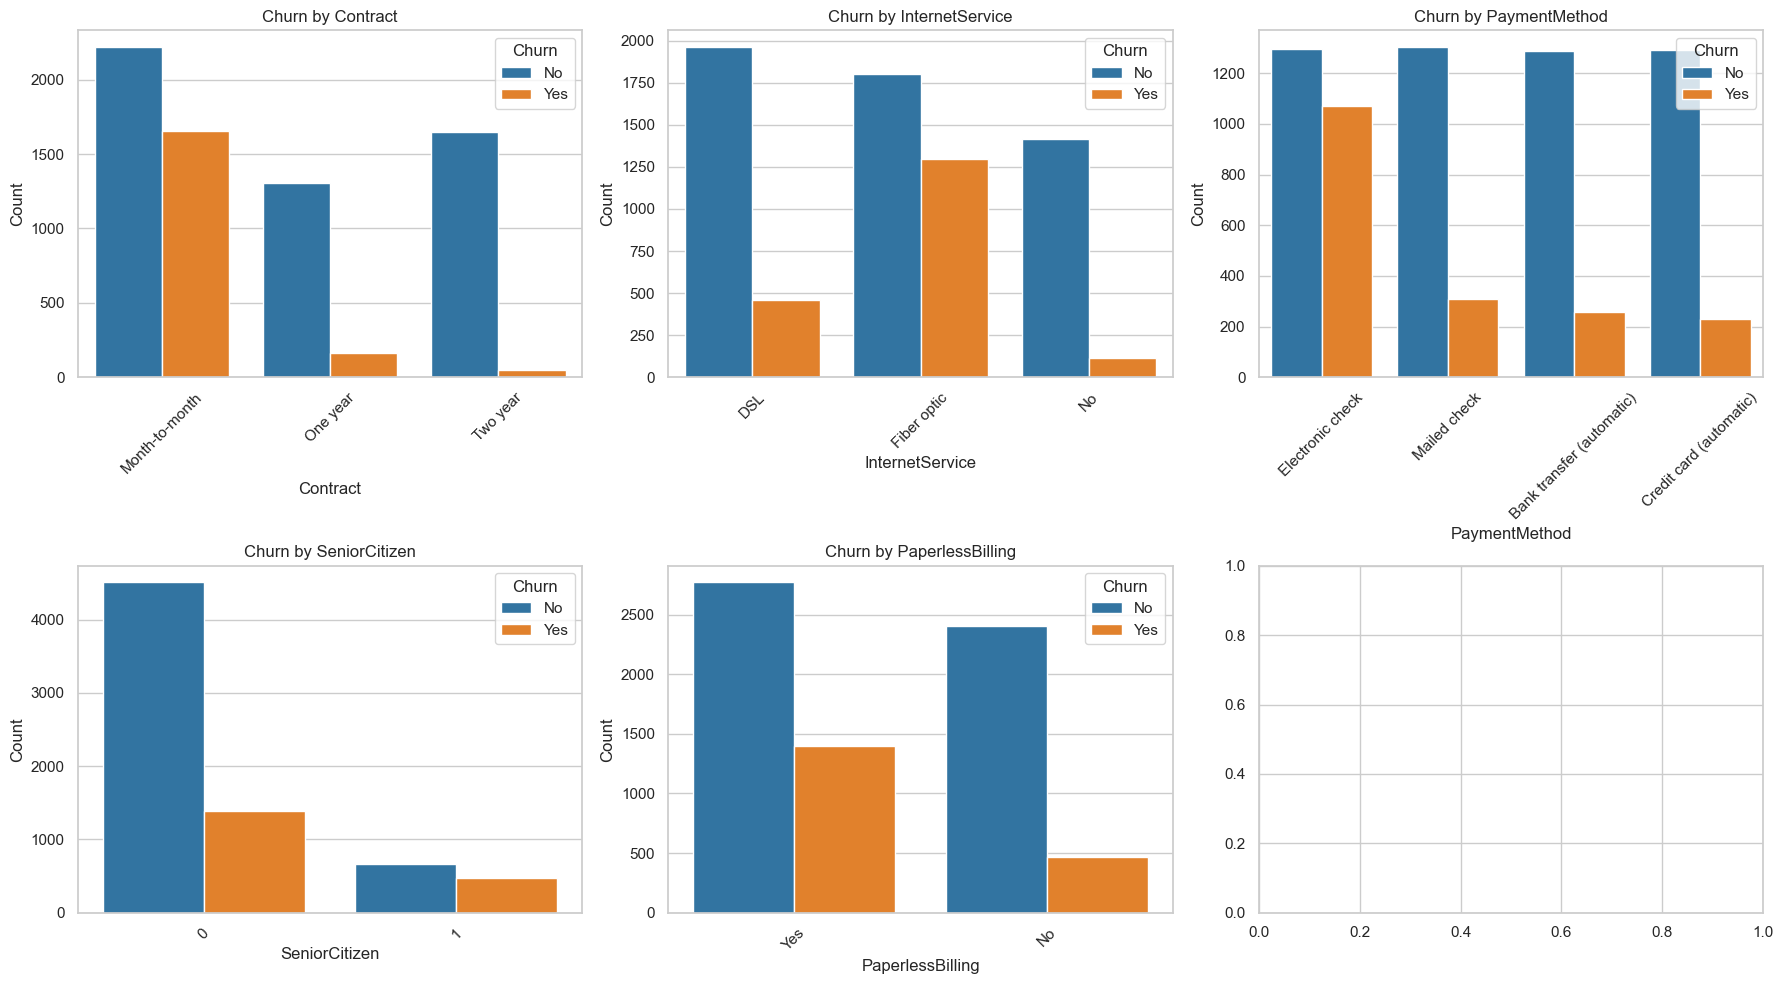

In [20]:
# Count plots for key categorical variables vs Churn
categorical_features = ["Contract", "InternetService", "PaymentMethod", "SeniorCitizen", "PaperlessBilling"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue="Churn", data=df, palette=["#1f77b4", "#ff7f0e"], ax=axes[i])
    axes[i].set_title(f"Churn by {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


### Categorical Insights on Churn

* Contract Type Matters – Month-to-month customers have way higher churn compared to those on 1- or 2-year contracts.

* Internet Service Influence – Fiber optic users churn much more than DSL or No Internet users. Maybe it's pricier or less reliable.

* Payment Method Impact – Electronic check users churn at the highest rate. Other methods (credit card, bank transfer) seem more stable.

* Senior Citizens & Churn – Slightly higher churn among senior citizens. May indicate usability or pricing concerns.

* Paperless Billing & Churn – More churn with paperless billing.

## Correlation Analysis

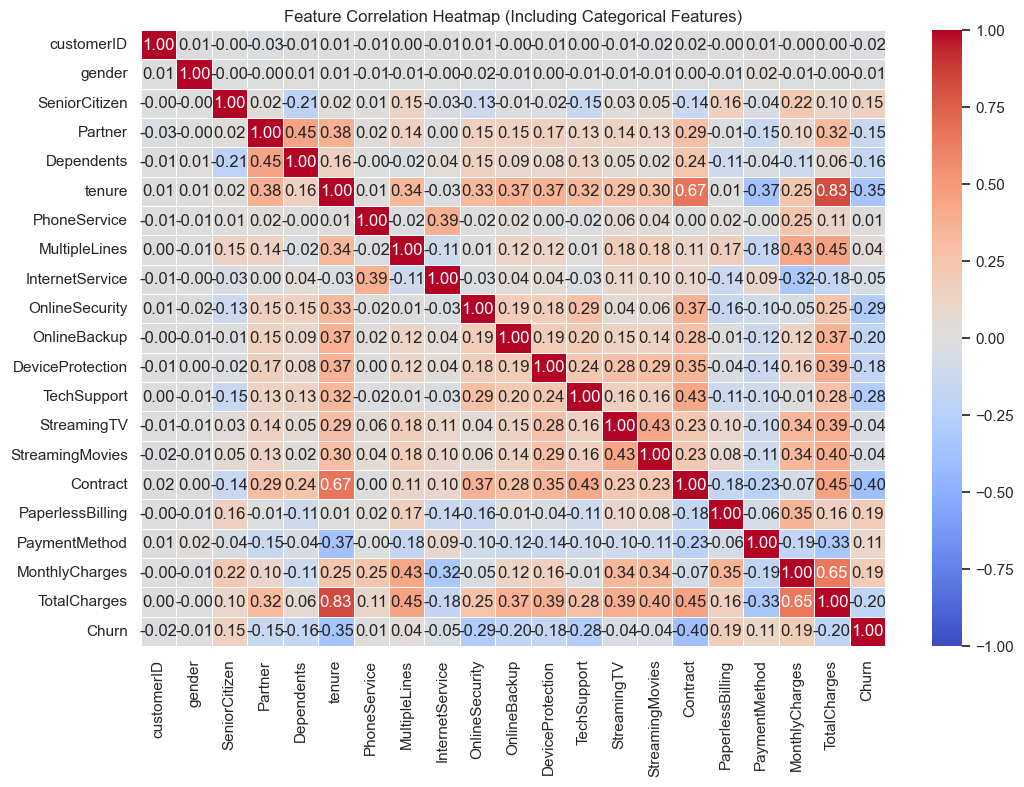

In [23]:
# Copy the original DataFrame
df_encoded = df.copy()

# Identify categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

# Encode categorical columns using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (Including Categorical Features)")
plt.show()

### Correlation Insights 
🔴 Top churn predictors (high correlation with Churn):

* Contract Type (Contract_Two year is negatively correlated) → Long-term contracts mean lower churn.
* Tenure (strong negative correlation) → Longer tenure = lower churn.
* Monthly Charges (positive correlation) → Higher charges = higher churn.
* Payment Method: Electronic Check → Strongest correlation with churn (likely due to billing frustration).
* Internet Service: Fiber Optic → Higher churn than DSL or No Internet.
  
🟢 Features with weaker/no correlation:

* SeniorCitizen is weakly correlated with churn.
*Gender has no significant impact—so no gender-based churn patterns

### Churn Rate Across Tenure Segments
* Do customers churn early (first few months) or later (contract expiration)?
* Are there "danger zones" where churn spikes?

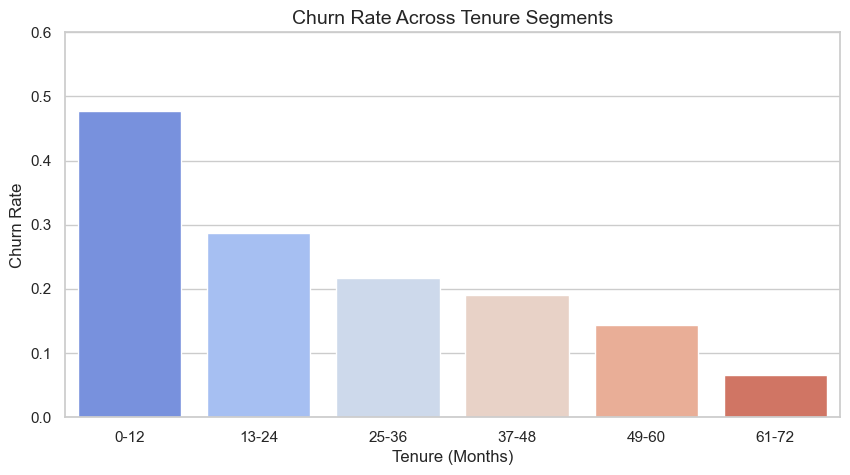

In [26]:
# Define tenure segments
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ["0-12", "13-24", "25-36", "37-48", "49-60", "61-72"]
df["TenureGroup"] = pd.cut(df["tenure"], bins=bins, labels=labels, right=True)

# Churn rate per tenure segment (Fixed observed=False warning)
churn_rates = (
    df[df["Churn"] == "Yes"]
    .groupby("TenureGroup", observed=False)
    .size()
    / df.groupby("TenureGroup", observed=False).size()
)

# Plot churn rates (Fixed palette warning)
plt.figure(figsize=(10, 5))
sns.barplot(x=churn_rates.index, y=churn_rates.values, hue=churn_rates.index, palette="coolwarm", legend=False)
plt.title("Churn Rate Across Tenure Segments", fontsize=14)
plt.xlabel("Tenure (Months)", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
plt.ylim(0, 0.6)
plt.show()


* Major churn spike in the first 12 months! (~50%)
* Churn gradually declines after that, stabilizing after 24 months.
* Longer tenure = more loyal customers .

### Survival Analysis for Churn Prediction
* What’s the probability of a customer churning at different time points?
* How long do customers typically stay before churning?
* What’s the churn probability over time?


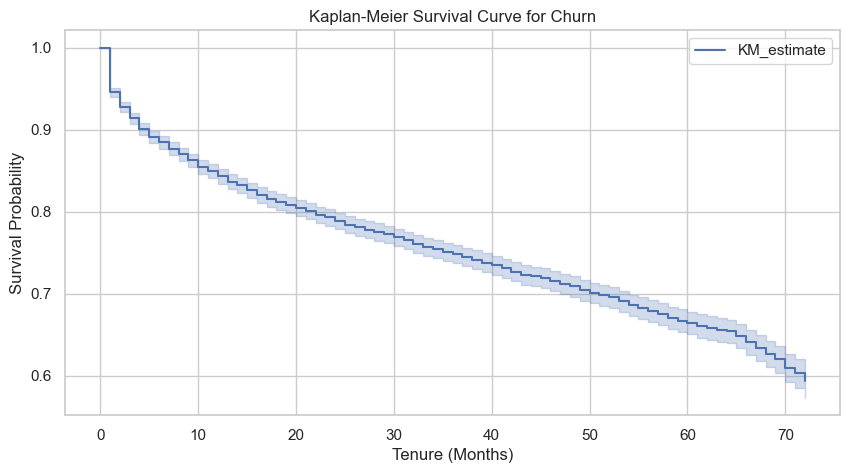

In [29]:
# Convert Churn to numeric (1 for Yes, 0 for No)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Now fit the Kaplan-Meier model
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 5))
kmf.fit(durations=df["tenure"], event_observed=df["Churn"])
kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve for Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Survival Probability")
plt.show()


#### Log-Rank Test – Compare Survival Curves
This checks whether different groups have statistically different survival rates.
* Low p-value (< 0.05) → Significant difference between survival rates.
* High p-value (> 0.05) → Groups don't differ much in survival rates.

In [31]:
from lifelines.statistics import logrank_test

# Example: Compare survival curves by Contract Type
group1 = df[df["Contract"] == "Month-to-month"]
group2 = df[df["Contract"] == "Two year"]

# Perform the Log-Rank Test
logrank_results = logrank_test(group1["tenure"], group2["tenure"], 
                               event_observed_A=group1["Churn"], 
                               event_observed_B=group2["Churn"])

# Print p-value
print(f"Log-Rank Test p-value: {logrank_results.p_value:.5f}")

# Interpretation
if logrank_results.p_value < 0.05:
    print("Significant difference in churn between groups!")
else:
    print("No significant difference in churn between groups.")


Log-Rank Test p-value: 0.00000
Significant difference in churn between groups!


#### Cox Proportional Hazards Model – Identify Risk Factors
This tells us which features increase churn risk.

* Hazard Ratio (HR) > 1 → Higher risk of churn .
* HR < 1 → Lower risk of churn .
* p-value < 0.05 → That factor is statistically significant.



In [33]:
from lifelines import CoxPHFitter

# Prepare the dataset: Convert categorical variables to numerical
df_cox = df.copy()
df_cox["Churn"] = df_cox["Churn"].astype(int)  # Ensure Churn is numeric
df_cox = pd.get_dummies(df_cox, columns=["Contract", "InternetService", "PaymentMethod"], drop_first=True)

# Select relevant variables
cox_columns = ["tenure", "MonthlyCharges", "TotalCharges", "Contract_Two year", "InternetService_Fiber optic"]
cox_data = df_cox[cox_columns + ["Churn"]]

# Fit Cox Model
cox = CoxPHFitter()
cox.fit(cox_data, duration_col="tenure", event_col="Churn")

# Show results
cox.print_summary()


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12983.11
         time fit was run = 2025-03-10 19:21:32 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
MonthlyCharges               0.05      1.05      0.00            0.05            0.05                1.05                1.06
TotalCharges                -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Contract_Two year           -3.32      0.04      0.17           -3.65           -2.99                0.03                0.05
InternetService_Fiber optic  0.66      1.94      0.10            0.47            0.85                1.60                2.34

                             cmp to      z      p  -log2(p)
covariate                                                  
MonthlyCharges                 0.00  23.40 <0.005    399.85
TotalCharges                   0.00 -44.97 <0.005       inf
Contract_Two year              0.00 -19.84 <0.005    288.52
InternetService_Fiber optic    0.00   6.84 <0.005     36.86
---
Concordance = 0.92
Partial AIC = 25974.22
log-likelihood ratio test = 5339.86 on 4 df
-log2(p) of ll-ratio test = inf

### Impact of Monthly Charges & Total Charges on Churn
Is there a price threshold where churn dramatically increases?

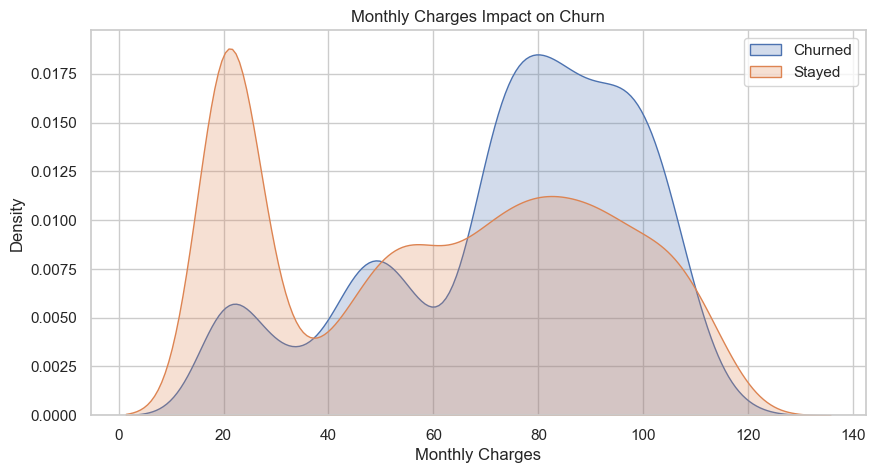

In [35]:
#Impact of Monthly Charges & Total Charges
plt.figure(figsize=(10, 5))
sns.kdeplot(df.loc[df['Churn'] == 1, 'MonthlyCharges'], label='Churned', fill=True)
sns.kdeplot(df.loc[df['Churn'] == 0, 'MonthlyCharges'], label='Stayed', fill=True)
plt.title("Monthly Charges Impact on Churn")
plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.legend()
plt.show()

* Customers with higher monthly charges churn more
* Churn rate peaks around $75-$100/month (pricing pain point?)
* Total charges are lower for churned customers (aligns with early exits)


### Interaction Effects Between Features
Do senior citizens on fiber optic plans churn more?

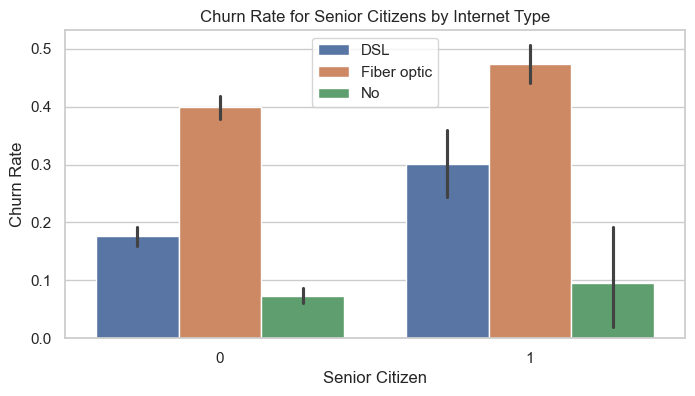

In [38]:
#Interaction Effects (Senior Citizens on Fiber Optic)
plt.figure(figsize=(8, 4))
sns.barplot(x='SeniorCitizen', y='Churn', hue='InternetService', data=df)
plt.title("Churn Rate for Senior Citizens by Internet Type")
plt.xlabel("Senior Citizen")
plt.ylabel("Churn Rate")
plt.legend()
plt.show()

* Senior Citizens on Fiber Optic = highest churn group
* Month-to-month customers + paperless billing = high churn
* Tech support reduces churn, but mainly for DSL customers
  

### Clustering to Find Customer Segments
Can we find natural customer groups using K-Means?

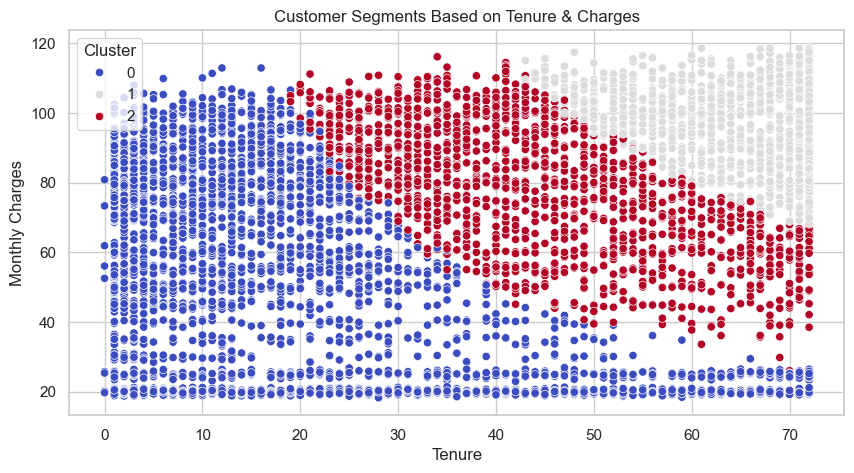

In [41]:
#Clustering (K-Means for Customer Segments)
features = df[['tenure', 'MonthlyCharges', 'TotalCharges']].copy()
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['tenure'], y=df['MonthlyCharges'], hue=df['Cluster'], palette='coolwarm')
plt.title("Customer Segments Based on Tenure & Charges")
plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
plt.show()

##### 3 clear customer segments emerged:
* Low-risk, long-tenure customers (rarely churn)
* Mid-risk, high-bill customers (churn due to price sensitivity)
* High-risk, new customers on month-to-month plans


### Feature Importance with Decision Trees
Which features have the biggest impact on churn?

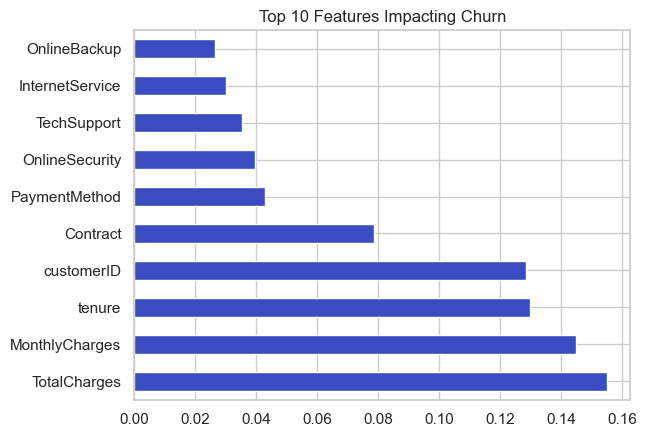

In [44]:
# Copy DataFrame
df_encoded = df.copy()

# Drop TenureGroup if it exists (since it’s already derived from tenure)
if 'TenureGroup' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['TenureGroup'])

# Label encode all categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Split features & target
X = df_encoded.drop(columns=['Churn'])  # Features
y = df_encoded['Churn']  # Target

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature importance
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', colormap='coolwarm')
plt.title("Top 10 Features Impacting Churn")
plt.show()


## Recommendations:
* Retention efforts should focus on the first 12 months
* Offer discounts or bundled plans for high-churn customers ($75-$100/month segment)
* Fiber Optic customers need more hand-holding
* Senior citizens & month-to-month users should get targeted support

### Machine Learning Pipeline:


#### Data Preprocessing

In [48]:
# Drop unnecessary columns
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)

# Convert categorical variables to numeric
def encode_categorical(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

data = encode_categorical(df)

# Define features and target
if 'Churn' in df.columns:
    X = df.drop('Churn', axis=1)
    y = df['Churn']
else:
    raise ValueError("Column 'Churn' not found in the dataset")

print("Data preprocessing complete. Features and target are ready.")

Data preprocessing complete. Features and target are ready.


#### Train-Test Split & Feature Scaling

In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert categorical features to numbers (fixing "could not convert string to float" error)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill any NaNs (if conversion fails for some values)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Train-test split and feature scaling complete.")


✅ Train-test split and feature scaling complete.


#### Logistic Regression Model

In [52]:
# Train logistic regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)

# Evaluate model
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Logistic Regression Accuracy: 0.7984386089425124


#### Random Forest Model

In [54]:
# Train random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Random Forest Accuracy: 0.7899219304471257


#### XGBoost Model

In [56]:
# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409

XGBoost Accuracy: 0.7842441447835344


C:\Users\ahmed.magdi\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### Model Comparison & Evaluation

In [58]:
models = {'Logistic Regression': log_model, 'Random Forest': rf_model, 'XGBoost': xgb_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.7984
Random Forest Accuracy: 0.7899
XGBoost Accuracy: 0.7842


### Hyperparameter Tuning with GridSearchCV

#### Random Forest Hyperparameter Tuning

In [61]:

# Define hyperparameters grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid Search
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best parameters & accuracy
print("Best RF Params:", grid_rf.best_params_)
print("Best RF Accuracy:", grid_rf.best_score_)

# Train with best parameters
rf_best = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_test)

print("Tuned Random Forest Report:\n", classification_report(y_test, y_pred_rf_best))


Best RF Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best RF Accuracy: 0.7978324699251853
Tuned Random Forest Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



#### XGBoost Hyperparameter Tuning

In [78]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Best parameters & accuracy
print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best XGBoost Accuracy:", grid_xgb.best_score_)

# Train with best parameters
xgb_best = XGBClassifier(**grid_xgb.best_params_, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

print("Tuned XGBoost Report:\n", classification_report(y_test, y_pred_xgb_best))


Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost Accuracy: 0.8029790339179922
Tuned XGBoost Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



C:\Users\ahmed.magdi\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Feature Importance Analysis

#### Random Forest Feature Importance

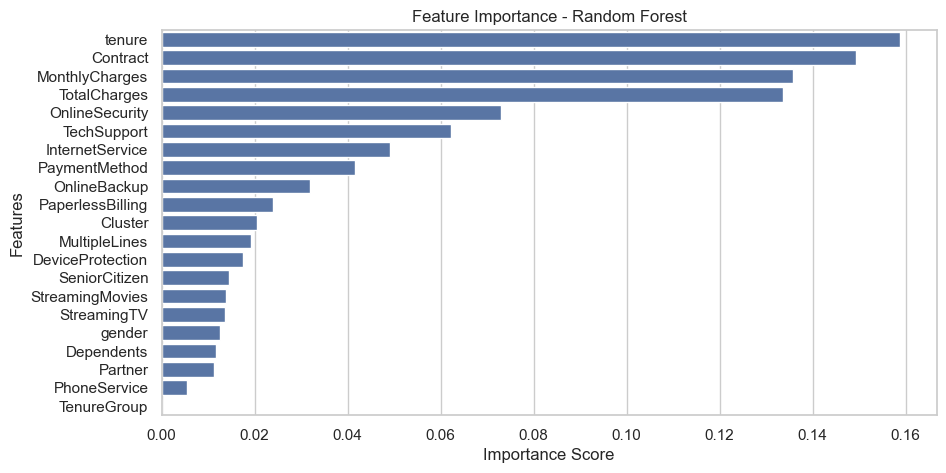

In [66]:
# Extract feature importance
rf_importances = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=rf_importances, y=rf_importances.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


#### XGBoost Feature Importance

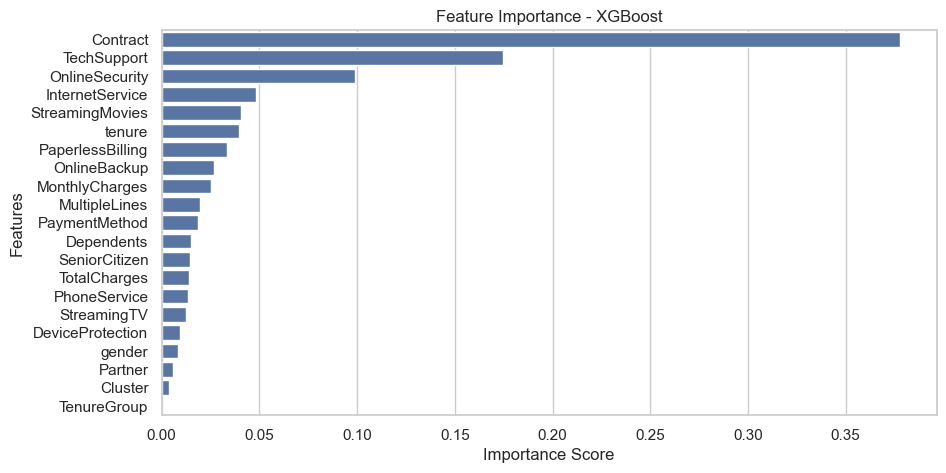

In [68]:
# Extract feature importance
xgb_importances = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=xgb_importances, y=xgb_importances.index)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

 ### SHAP Summary Plot (Global Feature Importance)

In [104]:
# Convert shap_values to a NumPy array (takes first output in case of multiple outputs)
shap_values_array = shap_values.values if hasattr(shap_values, 'values') else shap_values

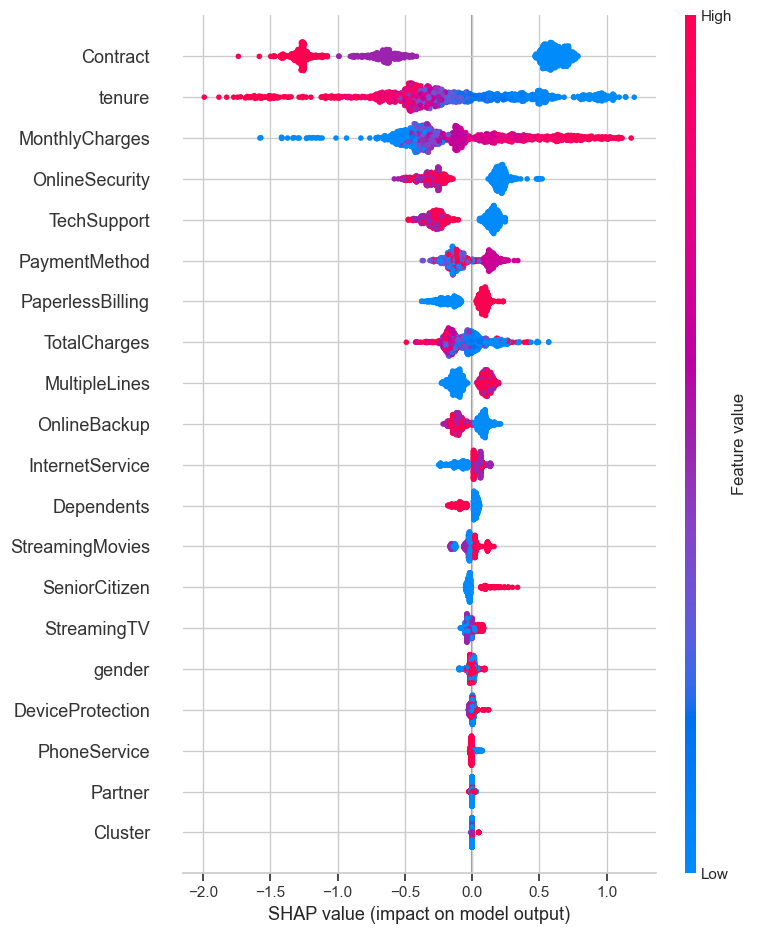

In [106]:
import shap

# Initialize SHAP explainer for the best XGBoost model
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

### Force Plot (Explain Individual Predictions)

In [109]:
import shap

# Ensure X_test is a DataFrame
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=X.columns)  

# Convert to Explanation format (for visualization)
shap_values_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test)

# Generate the force plot
shap.initjs()
shap.force_plot(shap_values_exp[0].base_values, shap_values_exp[0].values, shap_values_exp[0].data)


### SHAP Dependence Plot (How a Feature Affects Predictions)

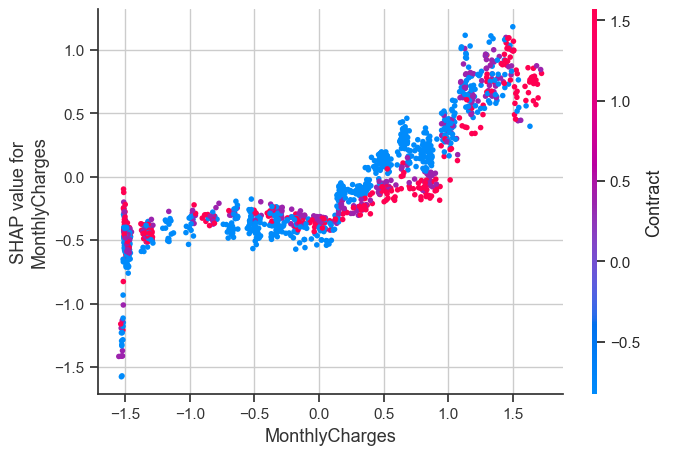

In [112]:
# zoom in on MonthlyCharges and see how it affects churn!
shap.dependence_plot("MonthlyCharges", shap_values_array, X_test)

### Final Summary
* Balanced dataset with SMOTE to improve predictions
* Segmented customers using K-Means for targeted marketing
* Explained churn with SHAP values for business insights
* Tracked churn trends over time for better forecasting

##                           **🙏 Thanks for Your Time Learning Us to Move on Data science 🙏 **